In [68]:
# helper functions
from scipy.misc import imresize
from scipy.signal import convolve2d
from scipy import fftpack

def make_radius_map(Nx,Ny,dx,dy,x0,y0):
    yy,xx = np.meshgrid(np.arange(Nx),np.arange(Nx))
    rr = np.sqrt(((xx-x0)*dx)**2 + ((yy-y0)*dy)**2)
    return rr

def gauss2d(rr,dx,dy,sig):
    g = np.exp(-rr**2/2./sig**2) / (2*np.pi*sig**2)
    g *= dx*dy
    return g

def make_xxyy_map(Nx,Ny,dx,dy,x0,y0):
    yy,xx = np.meshgrid(np.arange(Nx),np.arange(Nx))
    xx = (xx-x0) * dx
    yy  =(yy-y0) * dy
    return xx,yy

def gauss2d_ellipse(xx,yy,dx,dy,sigx,sigy):
    g = np.exp(-xx**2/2./sigx**2)*np.exp(-yy**2/2./sigy**2) / (2*np.pi*sigx*sigy)
    g *= dx*dy
    return g

def rebin_map_coarse(mapin,Nx,Ny):
    '''
    binning Nx,Ny mapin pixel to a large pixel.
    '''
    Nsx,Nsy = mapin.shape
    Nlx = round(Nsx/Nx)
    Nly = round(Nsy/Ny)
    
    rbmap=np.zeros([Nlx,Nly])
    for i in np.arange(Nlx):
        for j in np.arange(Nly):
            rbmap[i,j]=np.mean(mapin[i*Nx:(i+1)*Nx,j*Ny:(j+1)*Ny])

    return rbmap

def get_1D_profile(mapin,dx,dy, logbin=True, nbins = 15, binedges = []):
    rr = make_radius_map(mapin.shape[0],mapin.shape[1],dx,dy,Nsub,Nsub)
    rmin = min(rr[rr>0])
    rmax = max(rr[rr>0])

    if len(binedges)==0:
        if logbin: 
            binedges = np.logspace(np.log10(rmin),np.log10(rmax), nbins+1)
            bins = (binedges[:-1] + binedges[1:]) / 2
            binedges[0] = 0
            binedges[-1] *= 1.01
        else: 
            binedges = np.linspace(np.min(rmin), rmax, nbins+1)
            bins = np.sqrt(binedges[:-1] * binedges[1:])
            binedges[-1] *= 1.01

    else:
        bins = (binedges[:-1] + binedges[1:]) / 2
    
    P1D = np.histogram(rr, bins=binedges, weights=mapin)[0] \
         / np.histogram(rr, bins=binedges)[0]
    
    return P1D,bins

# demo the PSF_pix construction


[MoviePy] Building file plots/stack_process.gif with imageio


 98%|█████████▊| 50/51 [00:01<00:00, 44.91it/s]


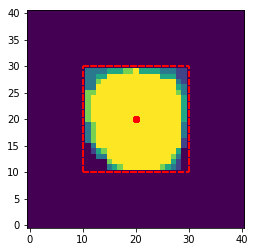

In [306]:
# random position stacking - delta function PSF
import glob
import moviepy.editor as mpy
import os

scale = 10 # subpixel is 'scale' times smaller than origial pixel
Npix = 2 # the stamp extend Npix pixels in each direction
Nsub = Npix*scale # stacking stamp: (Nsub*2+1)**2 subpixels
Nstack = 50 # number of random source stacking

stack = np.zeros([2*Nsub+1,2*Nsub+1])

src_coord = np.random.uniform(Nsub-0.5, Nsub+scale-1+0.5, [Nstack,2])

for i,[xsrc,ysrc] in enumerate(src_coord):
    rr = make_radius_map(2*Nsub+scale,2*Nsub+scale,1./scale,1./scale,xsrc,ysrc)
    psf = np.zeros_like(rr)
    psf[int(round(xsrc)),int(round(xsrc))] = 1
    psf_coarse = rebin_map_coarse(psf,scale,scale)
    
    psf_coarse = np.zeros([2 * Npix + 1, 2 * Npix + 1])
    psf_coarse[Npix,Npix] = 1
    psf_fine=imresize(psf_coarse,float(scale),interp='nearest',mode='F')
    stamp = psf_fine[int(round(xsrc)-Nsub):int(round(xsrc)+Nsub+1),\
                     int(round(ysrc)-Nsub):int(round(ysrc)+Nsub+1)]
    stack += stamp/Nstack
    
    plt.imshow(stack, vmin = 0, vmax = 0.1, origin='lower')
    plt.plot([Nsub - scale,Nsub - scale], [Nsub - scale,Nsub + scale], c = 'r', ls = '--')
    plt.plot([Nsub - scale,Nsub + scale], [Nsub - scale,Nsub - scale], c = 'r', ls = '--')
    plt.plot([Nsub + scale,Nsub + scale], [Nsub - scale,Nsub + scale], c = 'r', ls = '--')
    plt.plot([Nsub - scale,Nsub + scale], [Nsub + scale,Nsub + scale], c = 'r', ls = '--')
    plt.plot([Nsub],[Nsub], 'ro')
    plt.savefig('plots/stack_%d'%i)

gif_name = 'plots/stack_process'
file_list = glob.glob('plots/stack*.png')
list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) 
clip = mpy.ImageSequenceClip(file_list, fps=4)
clip.write_gif('{}.gif'.format(gif_name), fps=4)
for fname in file_list:
    os.remove(fname)

# Gaussian PSF_beam

In [71]:
# define paramters

scale = 10 # subpixel is 'scale' times smaller than origial pixel
Npix = 5 # the stamp extend Npix pixels in each direction
Nsub = Npix*scale # stacking stamp: (Nsub*2+1)**2 subpixels
sig = 0.5 # w.r.t. large pixel
Nstack = 1000 # number of random source stacking

pt_src = np.zeros([2 * Nsub + 1, 2 * Nsub + 1])
pt_src[Nsub, Nsub] = 1

rr = make_radius_map(2*Nsub + 1, 2*Nsub + 1, 1./scale, 1./scale, Npix * scale, Npix * scale)
psf_beam = gauss2d(rr,1./scale,1./scale,sig)

xx,yy = np.meshgrid(np.arange(2 * Nsub + 1), np.arange(2 * Nsub + 1))
xx = abs(xx - Nsub)
yy = abs(yy - Nsub)
psf_pix = (scale - xx)*(scale - yy)
psf_pix[(xx >= scale)] = 0
psf_pix[(yy >= scale)] = 0
psf_pix = psf_pix / np.sum(psf_pix)

psf_tot = convolve2d(psf_beam, psf_pix, mode='same')

In [3]:
# random position stacking - Gaussian PSF

stack = np.zeros([2*Nsub+1,2*Nsub+1])
src_coord = np.random.uniform(Nsub-0.5, Nsub+scale-1+0.5,[Nstack,2])
for xsrc,ysrc in src_coord:
    rr = make_radius_map(2*Nsub+scale,2*Nsub+scale,1./scale,1./scale,xsrc,ysrc)
    psf = gauss2d(rr,1./scale,1./scale,sig)
    psf_coarse = rebin_map_coarse(psf,scale,scale)
    psf_fine=imresize(psf_coarse,float(scale),interp='nearest',mode='F')
    stamp = psf_fine[int(round(xsrc)-Nsub):int(round(xsrc)+Nsub+1),\
                     int(round(ysrc)-Nsub):int(round(ysrc)+Nsub+1)]
    stack += stamp/Nstack

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


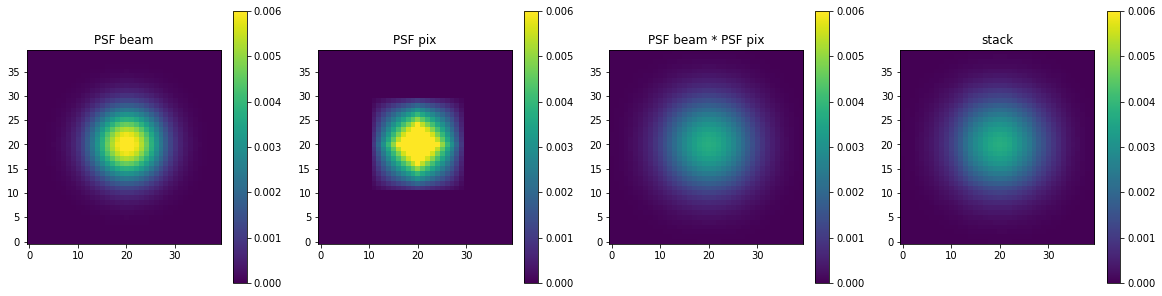

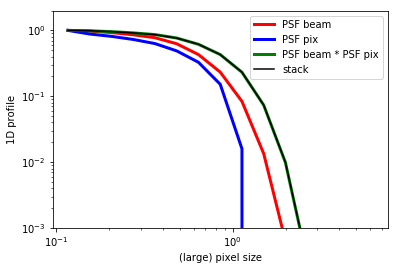

In [4]:
#
vmin = 0
vmax = 6e-3

pltmin = Nsub - 2 * scale
pltmax = Nsub + 2 * scale
f, ax = plt.subplots(1,4, figsize=(20,5))
im = ax[0].imshow(psf_beam[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[0])
ax[0].set_title('PSF beam')
im = ax[1].imshow(psf_pix[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[1])
ax[1].set_title('PSF pix')
im = ax[2].imshow(psf_tot[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[2])
ax[2].set_title('PSF beam * PSF pix')
im = ax[3].imshow(stack[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[3])
ax[3].set_title('stack')

plt.savefig('plots/stack_Gaussian2D', dpi = 100)

#
psf_beam1D,bins = get_1D_profile(psf_beam,1/scale,1/scale)
psf_pix1D,bins = get_1D_profile(psf_pix,1/scale,1/scale)
psf_tot1D,bins = get_1D_profile(psf_tot,1/scale,1/scale)
stack1D,bins = get_1D_profile(stack,1/scale,1/scale)

plt.figure()
plt.plot(bins,psf_beam1D/psf_beam1D[0],'r',lw=3,label='PSF beam')
plt.plot(bins,psf_pix1D/psf_pix1D[0],'b',lw=3,label='PSF pix')
plt.plot(bins,psf_tot1D/psf_tot1D[0],'g',lw=3,label='PSF beam * PSF pix')
plt.plot(bins,stack1D/stack1D[0],'k',lw=1.5,label='stack')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('(large) pixel size')
plt.ylabel('1D profile')
plt.legend(loc=0)
plt.ylim([1e-3,2e0])
plt.savefig('plots/stack_Gaussian1D', dpi = 200)

# Deconvolve pixel fucntion with RLD

In [312]:
# run RLD
u_t = stack
Niter = 30
for iiter in np.arange(Niter):
    c = convolve2d(u_t,psf_pix,mode='same')
    r = np.zeros_like(c)
    r[c!=0] = stack[c!=0]/c[c!=0]
    r[c==0] = 0
    u_t1 = u_t * convolve2d (r , psf_pix, mode='same')
    u_t = u_t1
psf_rl  = u_t / np.sum(u_t)

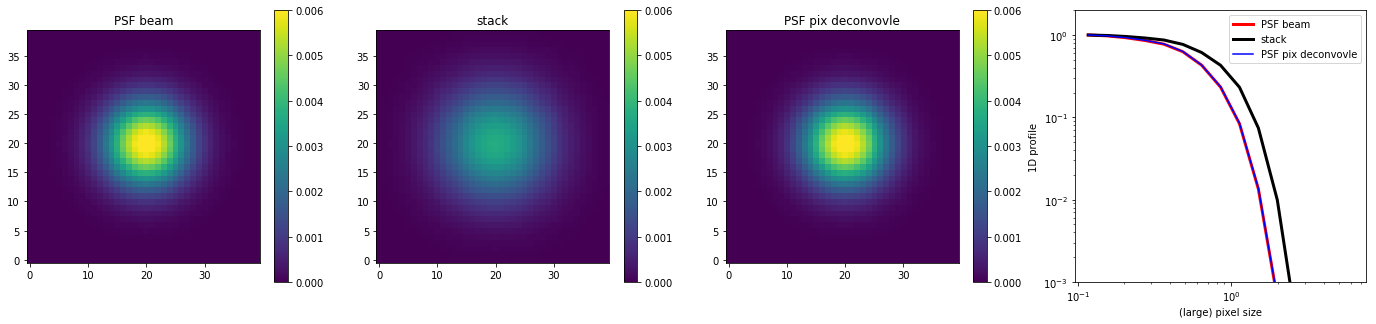

In [334]:
#
vmin = 0
vmax = 6e-3

pltmin = Nsub - 2 * scale
pltmax = Nsub + 2 * scale
f, ax = plt.subplots(1,4, figsize=(24,5))
im = ax[0].imshow(psf_beam[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[0])
ax[0].set_title('PSF beam')
im = ax[1].imshow(stack[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[1])
ax[1].set_title('stack')
im = ax[2].imshow(psf_rl[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[2])
ax[2].set_title('PSF pix deconvovle')


psf_beam1D,bins = get_1D_profile(psf_beam,1/scale,1/scale)
stack1D,bins = get_1D_profile(stack,1/scale,1/scale)
psf_rl1D,bins = get_1D_profile(psf_rl,1/scale,1/scale)

ax[3].plot(bins,psf_beam1D/psf_beam1D[0],'r',lw=3,label='PSF beam')
ax[3].plot(bins,stack1D/stack1D[0],'k',lw=3,label='stack')
ax[3].plot(bins,psf_rl1D/psf_rl1D[0],'b',lw=1.5,label='PSF pix deconvovle')

ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_xlabel('(large) pixel size')
ax[3].set_ylabel('1D profile')
ax[3].legend(loc=0)
ax[3].set_ylim([1e-3,2e0])
plt.savefig('plots/stack_Gaussian_deconv', dpi = 200)

========================================================
# Elliptical PSF_beam

In [48]:
# define paramters

scale = 10 # subpixel is 'scale' times smaller than origial pixel
Npix = 5 # the stamp extend Npix pixels in each direction
Nsub = Npix*scale # stacking stamp: (Nsub*2+1)**2 subpixels
sigx = 0.3
sigy = 0.5 # w.r.t. large pixel
Nstack = 1000 # number of random source stacking

pt_src = np.zeros([2 * Nsub + 1, 2 * Nsub + 1])
pt_src[Nsub, Nsub] = 1

xx,yy = make_xxyy_map(2*Nsub + 1, 2*Nsub + 1, 1./scale, 1./scale, Npix * scale, Npix * scale)
psf_beam = gauss2d_ellipse(xx,yy,1./scale,1./scale,sigx,sigy)

xx,yy = np.meshgrid(np.arange(2 * Nsub + 1), np.arange(2 * Nsub + 1))
xx = abs(xx - Nsub)
yy = abs(yy - Nsub)
psf_pix = (scale - xx)*(scale - yy)
psf_pix[(xx >= scale)] = 0
psf_pix[(yy >= scale)] = 0
psf_pix = psf_pix / np.sum(psf_pix)

psf_tot = convolve2d(psf_beam, psf_pix, mode='same')

# random position stacking - Gaussian PSF

stack = np.zeros([2*Nsub+1,2*Nsub+1])
src_coord = np.random.uniform(Nsub-0.5, Nsub+scale-1+0.5,[Nstack,2])
for xsrc,ysrc in src_coord:
    xx,yy = make_xxyy_map(2*Nsub+scale,2*Nsub+scale,1./scale,1./scale,xsrc,ysrc)
    psf = gauss2d_ellipse(xx,yy,1./scale,1./scale,sigx,sigy)
    psf_coarse = rebin_map_coarse(psf,scale,scale)
    psf_fine=imresize(psf_coarse, float(scale),interp='nearest',mode='F')
    stamp = psf_fine[int(round(xsrc)-Nsub):int(round(xsrc)+Nsub+1),\
                     int(round(ysrc)-Nsub):int(round(ysrc)+Nsub+1)]
    stack += stamp/Nstack

#run RLD
u_t = stack
Niter = 30
for iiter in np.arange(Niter):
    c = convolve2d(u_t,psf_pix,mode='same')
    r = np.zeros_like(c)
    r[c!=0] = stack[c!=0]/c[c!=0]
    r[c==0] = 0
    u_t1 = u_t * convolve2d (r , psf_pix, mode='same')
    u_t = u_t1
psf_rl  = u_t / np.sum(u_t)

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


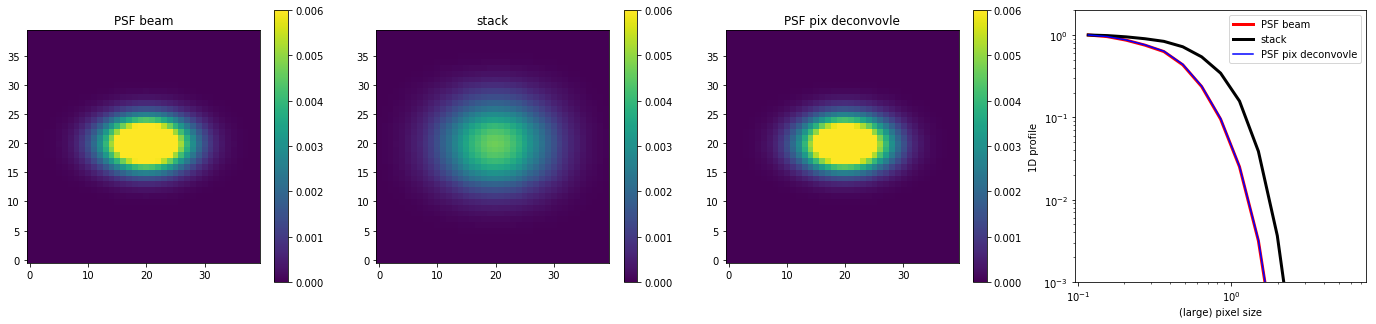

In [50]:
#
vmin = 0
vmax = 6e-3

pltmin = Nsub - 2 * scale
pltmax = Nsub + 2 * scale
f, ax = plt.subplots(1,4, figsize=(24,5))
im = ax[0].imshow(psf_beam[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[0])
ax[0].set_title('PSF beam')
im = ax[1].imshow(stack[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[1])
ax[1].set_title('stack')
im = ax[2].imshow(psf_rl[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[2])
ax[2].set_title('PSF pix deconvovle')


psf_beam1D,bins = get_1D_profile(psf_beam,1/scale,1/scale)
stack1D,bins = get_1D_profile(stack,1/scale,1/scale)
psf_rl1D,bins = get_1D_profile(psf_rl,1/scale,1/scale)

ax[3].plot(bins,psf_beam1D/psf_beam1D[0],'r',lw=3,label='PSF beam')
ax[3].plot(bins,stack1D/stack1D[0],'k',lw=3,label='stack')
ax[3].plot(bins,psf_rl1D/psf_rl1D[0],'b',lw=1.5,label='PSF pix deconvovle')

ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_xlabel('(large) pixel size')
ax[3].set_ylabel('1D profile')
ax[3].legend(loc=0)
ax[3].set_ylim([1e-3,2e0])
plt.savefig('plots/stack_Gaussian_deconv_ellipse', dpi = 200)

========================================================
# Deconvolve with noise

sig_N = 0.05 I_src

In [20]:
# define paramters

scale = 10 # subpixel is 'scale' times smaller than origial pixel
Npix = 5 # the stamp extend Npix pixels in each direction
Nsub = Npix*scale # stacking stamp: (Nsub*2+1)**2 subpixels
sig = 0.5 # w.r.t. large pixel
Nstack = 1000 # number of random source stacking

sig_n = 0.05

pt_src = np.zeros([2 * Nsub + 1, 2 * Nsub + 1])
pt_src[Nsub, Nsub] = 1

rr = make_radius_map(2*Nsub + 1, 2*Nsub + 1, 1./scale, 1./scale, Npix * scale, Npix * scale)
psf_beam = gauss2d(rr,1./scale,1./scale,sig)

xx,yy = np.meshgrid(np.arange(2 * Nsub + 1), np.arange(2 * Nsub + 1))
xx = abs(xx - Nsub)
yy = abs(yy - Nsub)
psf_pix = (scale - xx)*(scale - yy)
psf_pix[(xx >= scale)] = 0
psf_pix[(yy >= scale)] = 0
psf_pix = psf_pix / np.sum(psf_pix)

psf_tot = convolve2d(psf_beam, psf_pix, mode='same')

# random position stacking - Gaussian PSF

stack = np.zeros([2*Nsub+1,2*Nsub+1])
src_coord = np.random.uniform(Nsub-0.5, Nsub+scale-1+0.5,[Nstack,2])
for xsrc,ysrc in src_coord:
    rr = make_radius_map(2*Nsub+scale,2*Nsub+scale,1./scale,1./scale,xsrc,ysrc)
    psf = gauss2d(rr,1./scale,1./scale,sig)
    psf_coarse = rebin_map_coarse(psf,scale,scale) * scale**2
    psf_coarse += np.random.normal(scale= sig_n,size = psf_coarse.shape) 
    psf_fine=imresize(psf_coarse / scale**2, float(scale),interp='nearest',mode='F')
    stamp = psf_fine[int(round(xsrc)-Nsub):int(round(xsrc)+Nsub+1),\
                     int(round(ysrc)-Nsub):int(round(ysrc)+Nsub+1)]
    stack += stamp/Nstack

#run RLD
u_t = stack
Niter = 100
for iiter in np.arange(Niter):
    c = convolve2d(u_t,psf_pix,mode='same')
    r = np.zeros_like(c)
    r[c!=0] = stack[c!=0]/c[c!=0]
    r[c==0] = 0
    u_t1 = u_t * convolve2d (r , psf_pix, mode='same')
    u_t = u_t1
psf_rl  = u_t / np.sum(u_t)

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


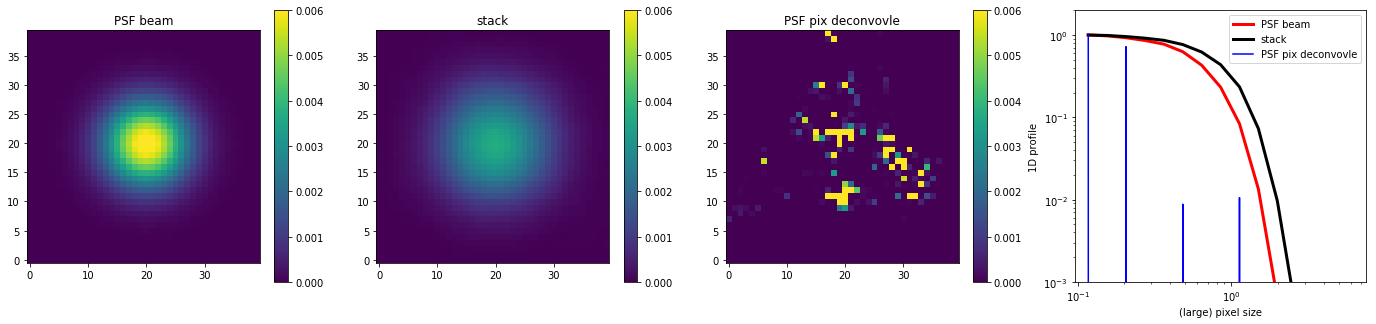

In [57]:
#
vmin = 0
vmax = 6e-3

pltmin = Nsub - 2 * scale
pltmax = Nsub + 2 * scale
f, ax = plt.subplots(1,4, figsize=(24,5))
im = ax[0].imshow(psf_beam[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[0])
ax[0].set_title('PSF beam')
im = ax[1].imshow(stack[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[1])
ax[1].set_title('stack')
im = ax[2].imshow(psf_rl[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[2])
ax[2].set_title('PSF pix deconvovle')


psf_beam1D,bins = get_1D_profile(psf_beam,1/scale,1/scale)
stack1D,bins = get_1D_profile(stack,1/scale,1/scale)
psf_rl1D,bins = get_1D_profile(psf_rl,1/scale,1/scale)

ax[3].plot(bins,psf_beam1D/psf_beam1D[0],'r',lw=3,label='PSF beam')
ax[3].plot(bins,stack1D/stack1D[0],'k',lw=3,label='stack')
ax[3].plot(bins,psf_rl1D/psf_rl1D[0],'b',lw=1.5,label='PSF pix deconvovle')

ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_xlabel('(large) pixel size')
ax[3].set_ylabel('1D profile')
ax[3].legend(loc=0)
ax[3].set_ylim([1e-3,2e0])
plt.savefig('plots/stack_Gaussian_deconv_noise5', dpi = 200)

sig_N = 0.01 I_src

In [60]:
# define paramters

scale = 10 # subpixel is 'scale' times smaller than origial pixel
Npix = 5 # the stamp extend Npix pixels in each direction
Nsub = Npix*scale # stacking stamp: (Nsub*2+1)**2 subpixels
sig = 0.5 # w.r.t. large pixel
Nstack = 1000 # number of random source stacking

sig_n = 0.01

pt_src = np.zeros([2 * Nsub + 1, 2 * Nsub + 1])
pt_src[Nsub, Nsub] = 1

rr = make_radius_map(2*Nsub + 1, 2*Nsub + 1, 1./scale, 1./scale, Npix * scale, Npix * scale)
psf_beam = gauss2d(rr,1./scale,1./scale,sig)

xx,yy = np.meshgrid(np.arange(2 * Nsub + 1), np.arange(2 * Nsub + 1))
xx = abs(xx - Nsub)
yy = abs(yy - Nsub)
psf_pix = (scale - xx)*(scale - yy)
psf_pix[(xx >= scale)] = 0
psf_pix[(yy >= scale)] = 0
psf_pix = psf_pix / np.sum(psf_pix)

psf_tot = convolve2d(psf_beam, psf_pix, mode='same')

# random position stacking - Gaussian PSF

stack = np.zeros([2*Nsub+1,2*Nsub+1])
src_coord = np.random.uniform(Nsub-0.5, Nsub+scale-1+0.5,[Nstack,2])
for xsrc,ysrc in src_coord:
    rr = make_radius_map(2*Nsub+scale,2*Nsub+scale,1./scale,1./scale,xsrc,ysrc)
    psf = gauss2d(rr,1./scale,1./scale,sig)
    psf_coarse = rebin_map_coarse(psf,scale,scale) * scale**2
    psf_coarse += np.random.normal(scale= sig_n,size = psf_coarse.shape) 
    psf_fine=imresize(psf_coarse / scale**2, float(scale),interp='nearest',mode='F')
    stamp = psf_fine[int(round(xsrc)-Nsub):int(round(xsrc)+Nsub+1),\
                     int(round(ysrc)-Nsub):int(round(ysrc)+Nsub+1)]
    stack += stamp/Nstack

#run RLD
u_t = stack
Niter = 100
for iiter in np.arange(Niter):
    c = convolve2d(u_t,psf_pix,mode='same')
    r = np.zeros_like(c)
    r[c!=0] = stack[c!=0]/c[c!=0]
    r[c==0] = 0
    u_t1 = u_t * convolve2d (r , psf_pix, mode='same')
    u_t = u_t1
psf_rl  = u_t / np.sum(u_t)

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


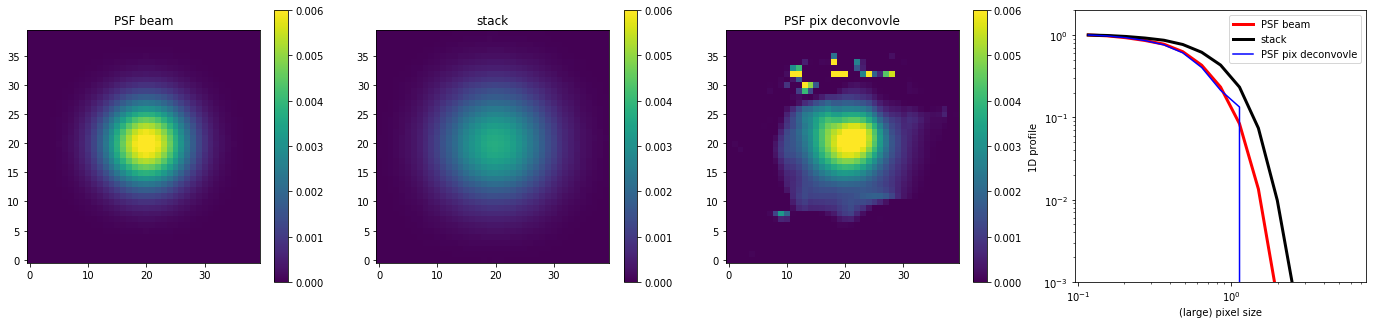

In [61]:
#
vmin = 0
vmax = 6e-3

pltmin = Nsub - 2 * scale
pltmax = Nsub + 2 * scale
f, ax = plt.subplots(1,4, figsize=(24,5))
im = ax[0].imshow(psf_beam[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[0])
ax[0].set_title('PSF beam')
im = ax[1].imshow(stack[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[1])
ax[1].set_title('stack')
im = ax[2].imshow(psf_rl[pltmin:pltmax, pltmin:pltmax], vmin = vmin, vmax = vmax, origin='lower')
plt.colorbar(im, ax = ax[2])
ax[2].set_title('PSF pix deconvovle')


psf_beam1D,bins = get_1D_profile(psf_beam,1/scale,1/scale)
stack1D,bins = get_1D_profile(stack,1/scale,1/scale)
psf_rl1D,bins = get_1D_profile(psf_rl,1/scale,1/scale)

ax[3].plot(bins,psf_beam1D/psf_beam1D[0],'r',lw=3,label='PSF beam')
ax[3].plot(bins,stack1D/stack1D[0],'k',lw=3,label='stack')
ax[3].plot(bins,psf_rl1D/psf_rl1D[0],'b',lw=1.5,label='PSF pix deconvovle')

ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_xlabel('(large) pixel size')
ax[3].set_ylabel('1D profile')
ax[3].legend(loc=0)
ax[3].set_ylim([1e-3,2e0])
plt.savefig('plots/stack_Gaussian_deconv_noise1', dpi = 200)

We cannot directly deconvolve the noisy map !!!